# 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geohash2
%matplotlib inline

# 2. Reading in Data

In [2]:
df = pd.read_csv('training.csv')

# 3. Exploratory Data Analysis (EDA)

Our aim with EDA is two fold here:

- Get an idea about distribution of demand during the given period, by day, by hour, by minute, by day-of-week, etc.
- Figure out the time period to which this data belongs, so we can conduct time series forecasting.

In [3]:
df.shape

(4206321, 4)

In [4]:
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [5]:
df['hour'] = df['timestamp'].map(lambda x: x.split(':')[0]).astype('int')
df['minute'] = df['timestamp'].map(lambda x: x.split(':')[1]).astype('int')

In [6]:
df.head()

,geohash6,day,timestamp,demand,hour,minute
0,qp03wc,18,20:0,0.020072,20,0
1,qp03pn,10,14:30,0.024721,14,30
2,qp09sw,9,6:15,0.102821,6,15
3,qp0991,32,5:0,0.088755,5,0
4,qp090q,15,4:0,0.074468,4,0


In [7]:
df.columns

Index(['geohash6', 'day', 'timestamp', 'demand', 'hour', 'minute'], dtype='object')

In [8]:
df.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
hour         0
minute       0
dtype: int64

In [9]:
df.sort_values(['day', 'hour', 'minute'], axis=0, inplace=True)

In [10]:
# df['lat'] = df['geohash6'].map(lambda x: geohash2.decode(x)[0])
# df['lon'] = df['geohash6'].map(lambda x: geohash2.decode(x)[1]) 

In [11]:
df['day_mod_7'] = df['day'].map(lambda x: x%7)

In [12]:
df.head()

,geohash6,day,timestamp,demand,hour,minute,day_mod_7
2289,qp09sx,1,0:0,0.021212,0,0,1
3149,qp0dhg,1,0:0,0.013217,0,0,1
11052,qp03x5,1,0:0,0.157956,0,0,1
23011,qp09bw,1,0:0,0.001262,0,0,1
26180,qp03wn,1,0:0,0.032721,0,0,1


In [13]:
df.corr()

,day,demand,hour,minute,day_mod_7
day,1.000000,0.023643,-0.000031,0.000121,0.039480
demand,0.023643,1.000000,-0.085078,-0.002702,-0.022668
hour,-0.000031,-0.085078,1.000000,0.002456,0.004612
minute,0.000121,-0.002702,0.002456,1.000000,0.000157
day_mod_7,0.039480,-0.022668,0.004612,0.000157,1.000000


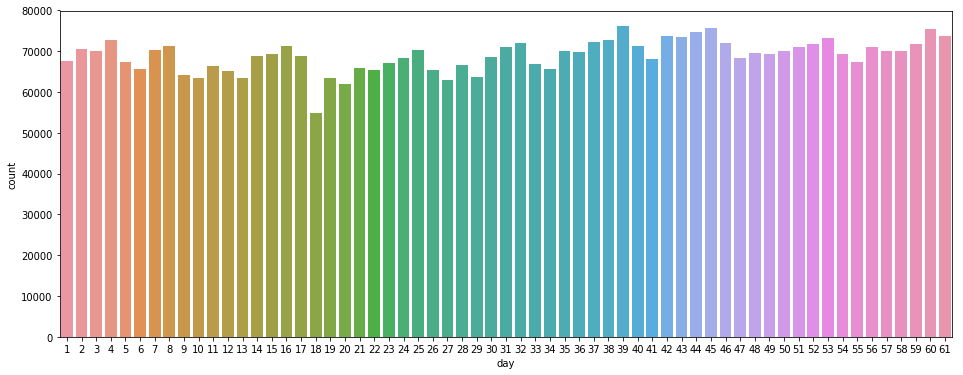

In [14]:
plt.figure(figsize=(16,6))
sns.countplot(df['day']);

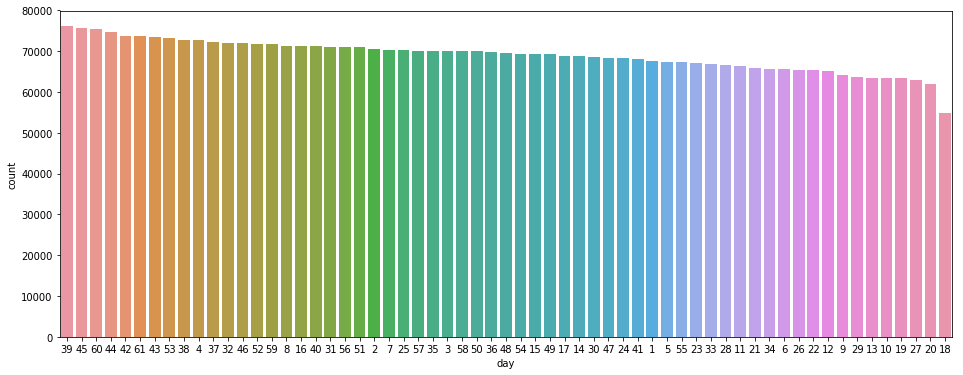

In [15]:
plt.figure(figsize=(16,6))
sns.countplot(df['day'], order = df['day'].value_counts().index);

Day 39 seems to be the busiest.

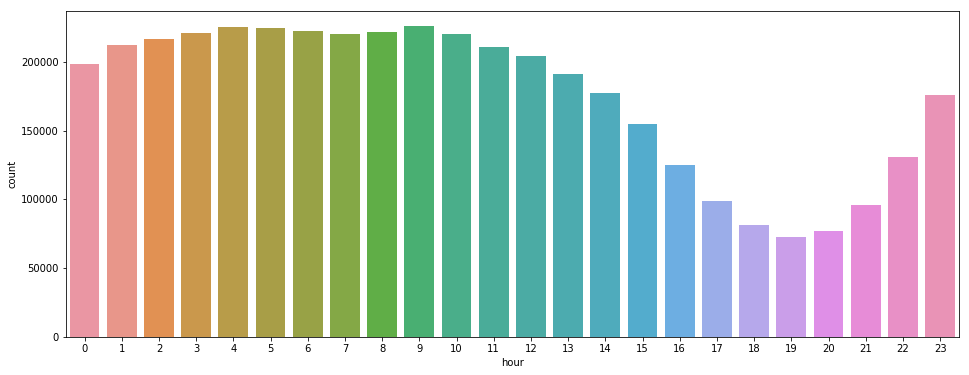

In [16]:
plt.figure(figsize=(16,6))
sns.countplot(df['hour']);

It seems that demand peaks in the morning hours, as opposed to night.

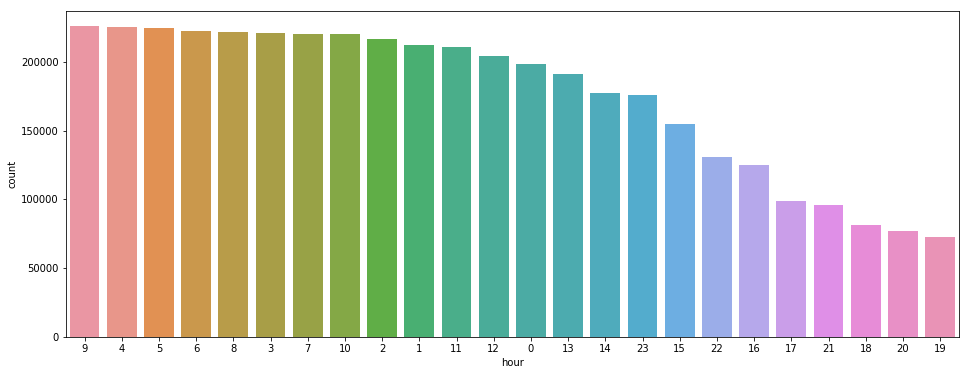

In [17]:
plt.figure(figsize=(16,6))
sns.countplot(df['hour'], order=df['hour'].value_counts().index);

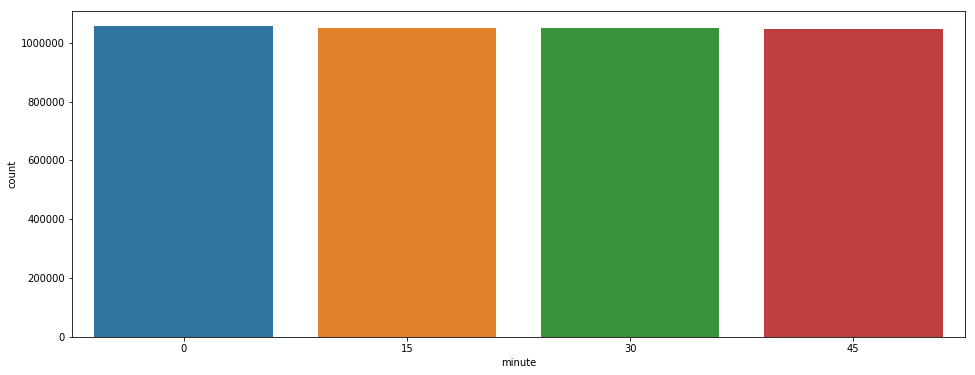

In [18]:
plt.figure(figsize=(16,6))
sns.countplot(df['minute'], order=df['minute'].value_counts().index);

In [19]:
df.groupby('minute')['demand'].mean().sort_values(ascending=False)

minute
0     0.105726
15    0.105225
30    0.104832
45    0.104575
Name: demand, dtype: float64

In [20]:
a = df.groupby(['day', 'hour', 'minute'], as_index=False)['demand'].mean()
a.groupby(['minute'])['demand'].mean()

minute
0     0.096063
15    0.095614
30    0.095014
45    0.094632
Name: demand, dtype: float64

We have a nearly uniform distribution for quarterly minute buckets, both for absolute counts and aggregated demand. We split aggregated demand using two ways: in general, disregarding days. Followed by grouping the data first, and then aggregating by minute.

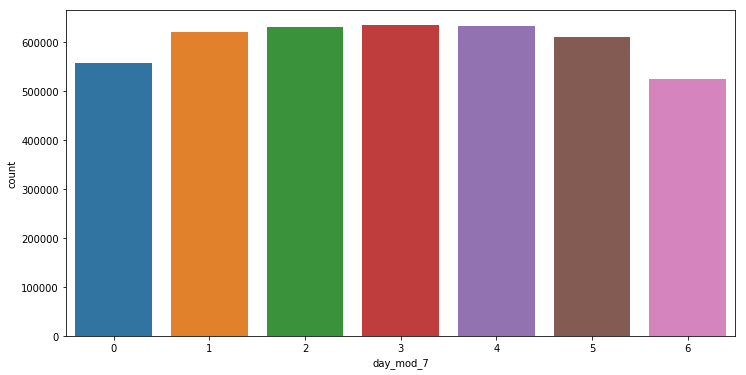

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(df['day_mod_7']);

In [22]:
df['day_mod_7'].value_counts().sort_values(ascending=False)

3    633567
4    632786
2    629281
1    620418
5    610482
0    555733
6    524054
Name: day_mod_7, dtype: int64

In [23]:
df.groupby('day_mod_7')['demand'].mean().sort_values(ascending=False)

day_mod_7
4    0.116981
3    0.111587
2    0.109509
0    0.104689
1    0.103763
5    0.099302
6    0.086315
Name: demand, dtype: float64

In [24]:
by_dow = df.groupby('day_mod_7')['demand'].mean()

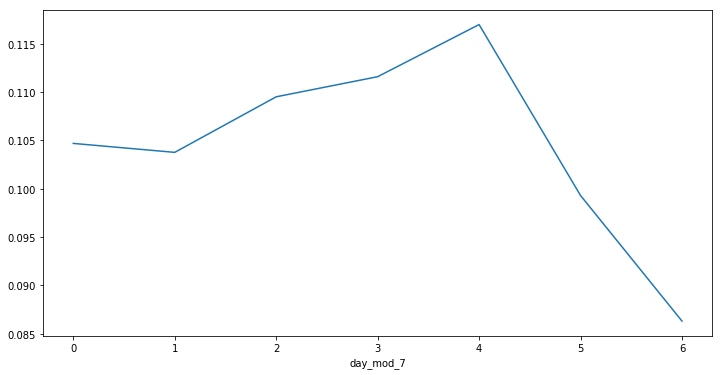

In [25]:
plt.figure(figsize=(12,6))
plt.xticks(np.arange(7))
sns.lineplot(y=by_dow.values, x=by_dow.index);

We can introduce further granularity in our analysis by first grouping on day of week (modulo), then on the hour of that day, and averaging that number. It would give us day-of-week hourly analysis. We can then further take mean of that to give us day-of-week averages. This will help us narrow down what day-of-week demand is highest, and we can guess the day by making some assumptions.

In [26]:
weekly_by_hour = df.groupby(['day_mod_7', 'hour'], as_index=False)['demand'].mean()

In [27]:
weekly = weekly_by_hour.groupby('day_mod_7')['demand'].mean().sort_values(ascending=False)

In [28]:
weekly

day_mod_7
4    0.108523
3    0.102511
2    0.099905
0    0.094670
1    0.094311
5    0.090450
6    0.079389
Name: demand, dtype: float64

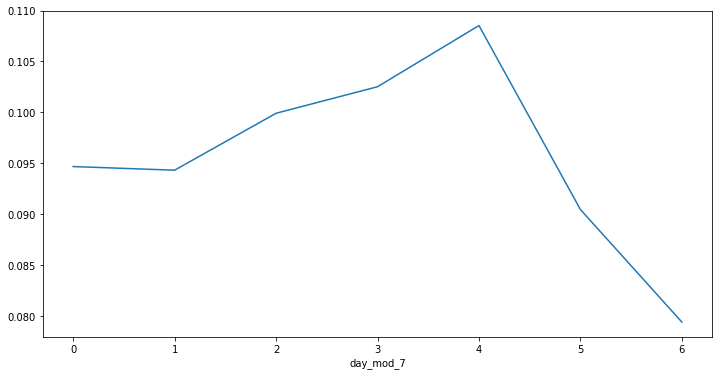

In [29]:
plt.figure(figsize=(12,6))
plt.xticks(np.arange(7))
sns.lineplot(y=weekly.values, x=weekly.index);

**ASSUMPTION**: We make the assumption that busiest day is Sunday. We can see from above that day 4 is busiest in terms of average demand. We deem day 4 as sunday. That makes our week look like:

- Day 4: Sunday
- Day 5: Monday
- Day 6: Tuesday
- Day 0: Wednesday
- Day 1: Thursday
- Day 2: Friday
- Day 3: Saturday

Given high demands on days 2, 3 and 4, it seems that our assumption makes a bit of sense.

**FURTHER ASSUMPTIONS**:

- Year is 2018 (we assume data is from last year).
- Day 1 is DAY-OF-WEEK 1 which is Thursday, and day 1 is 1st of our particular month.
- 61 days is 2 whole months. 
- One month is 30 days, another is 31 days.

So, we are looking for a month in 2018 that starts on Thursday. We will utilise the pendulum library of python which makes dealing with dates easier. Our intention is to go through year 2018 and see those months that start on a Thursday. We are looking for 31-30 days combo).

In [30]:
import pendulum

start = pendulum.datetime(2018, 1, 1)
end = pendulum.datetime(2019, 6, 13)

period = pendulum.period(start, end)

for dt in period.range('days'):
    if dt.day_of_week == pendulum.THURSDAY and dt.day == 1:
        print(dt.to_date_string(), "number of days:", 
              dt.end_of('month').day-dt.start_of('month').day+1)

2018-02-01 number of days: 28
2018-03-01 number of days: 31
2018-11-01 number of days: 30


We see that our options are either March-April 2018 or November-December 2018. We can go with either month. But I decided to go with recent two months analysis. 

So, our scenario is:
- Day 1-30: November 2018
- Day 31-61: December 2018

We continue with some further EDA.

In [31]:
by_hour = df.groupby('hour')['demand'].mean()

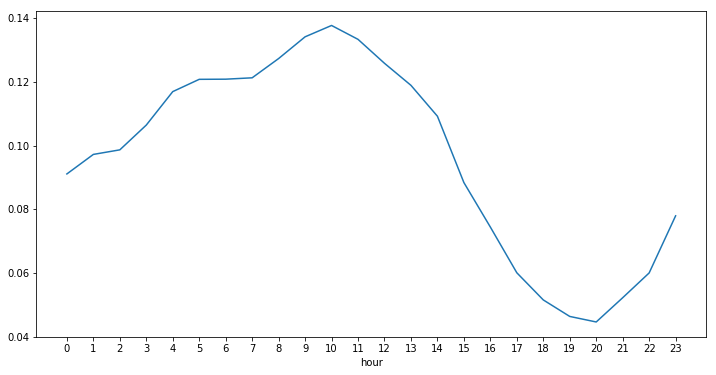

In [32]:
plt.figure(figsize=(12,6))
plt.xticks(np.arange(24))
sns.lineplot(y=by_hour.values, x=by_hour.index);

As seen above, demand increases steadily in the morning hours, peaking around 9-10 am (office going hours), and afterwards reduces until evening when it starts to pick up again (maybe people returning home).

In [33]:
by_day = df.groupby('day')['demand'].mean()

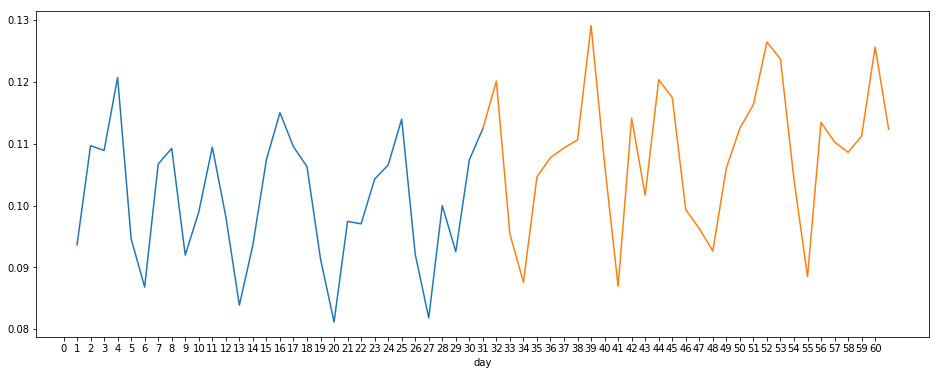

In [34]:
plt.figure(figsize=(16,6))
plt.xticks(np.arange(len(by_day)))
sns.lineplot(y=by_day.values[0:31], x=by_day.index[0:31]);
sns.lineplot(y=by_day.values[30:], x=by_day.index[30:]);

We see regular peaks and valleys which points towards weekends and weekdays demand expectation. We assume demand balloons on the weekends, and goes down on the weekdays. We also expect more demand at night on the weekends. Let's see if that is the case. 

In [35]:
weekly_data = df.groupby(['day_mod_7', 'hour'], as_index=False)['demand'].mean()

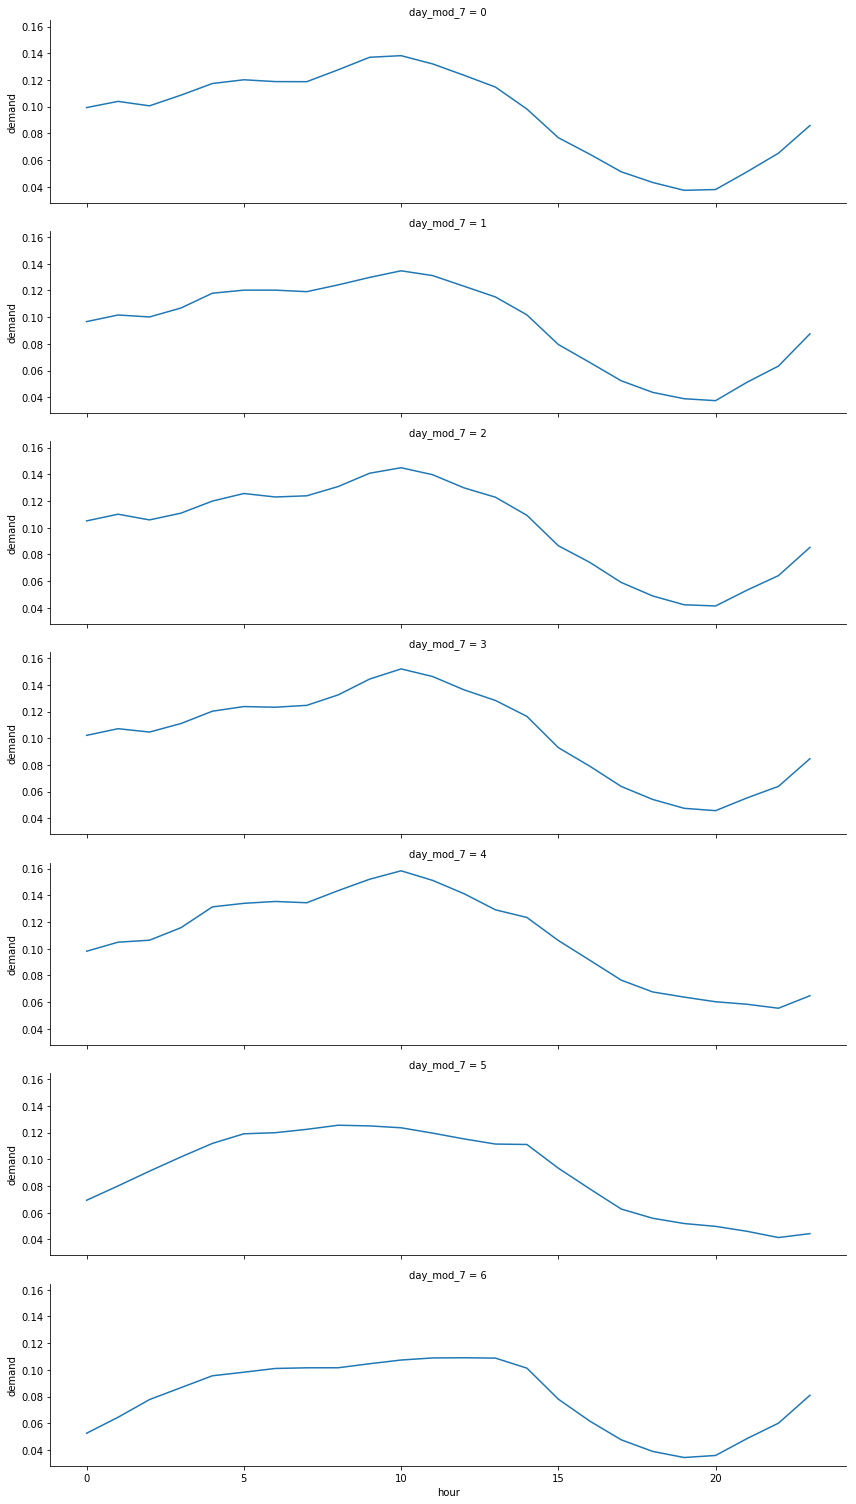

In [36]:
ordered_days = sorted(weekly_data.day_mod_7.value_counts().index)
g = sns.FacetGrid(weekly_data, 'day_mod_7', row_order=ordered_days,
                  height=3, aspect=4,)
g.map(sns.lineplot, 'hour', 'demand');

Note that day 0 is Wednesday. Individual days follow the general pattern established by aggregated weekly values. However, we do see that day 6 shows the most uptick towards the night, which is Tuesday by our assumptions. It is not immediately clear why.

Now we can proceed to the next phase of our analysis.

# 4. Data Preparation

We have a somewhat clear angle on what the data is like. Now we move on to the data preparation phase. As a first step, we need to create a time-series column which will enable us to conduct time-series forecasting. Based on our EDA, and several assumptions, we reached the following conclusion:

- Day 1-30: November, 2018
- Day 31-61: December, 2018.

In [37]:
df.head()

,geohash6,day,timestamp,demand,hour,minute,day_mod_7
2289,qp09sx,1,0:0,0.021212,0,0,1
3149,qp0dhg,1,0:0,0.013217,0,0,1
11052,qp03x5,1,0:0,0.157956,0,0,1
23011,qp09bw,1,0:0,0.001262,0,0,1
26180,qp03wn,1,0:0,0.032721,0,0,1


In [38]:
df['month'] = df['day'].map(lambda x: 11 if x in range(1,31) else 12)

In [39]:
df['year'] = 2018

In [40]:
df['day_of_month'] = df['day'].map(lambda x: x if x in range(1,31) else x-30)

In [41]:
df['datetime'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day_of_month, 
                                    hour=df.hour, minute=df.minute))

In [42]:
df.head()

,geohash6,day,timestamp,demand,hour,minute,day_mod_7,month,year,day_of_month,datetime
2289,qp09sx,1,0:0,0.021212,0,0,1,11,2018,1,2018-11-01
3149,qp0dhg,1,0:0,0.013217,0,0,1,11,2018,1,2018-11-01
11052,qp03x5,1,0:0,0.157956,0,0,1,11,2018,1,2018-11-01
23011,qp09bw,1,0:0,0.001262,0,0,1,11,2018,1,2018-11-01
26180,qp03wn,1,0:0,0.032721,0,0,1,11,2018,1,2018-11-01


Now we have got a datetime column, which gives the dataset a time-series feature. We have our dependent variable which is demand. Now, we apply forecasting techniques.

# 5. Forecasting Models

## 5.1 Forecasting without Geohash

We will use various techniques for forecasting, using Python libraries statsmodel and prophet, both of which make forecasting easy.

In [94]:
y = df[['demand', 'datetime']]

In [95]:
y['demand'].describe()

count    4.206321e+06
mean     1.050907e-01
std      1.592655e-01
min      3.092217e-09
25%      1.867379e-02
50%      5.043463e-02
75%      1.208644e-01
max      1.000000e+00
Name: demand, dtype: float64

In [96]:
y.set_index('datetime', inplace=True)

We resample our data into quarterly average demand for easy analysis.

In [97]:
y2 = y.resample('15Min').mean()

In [98]:
y2.isna().sum()

demand    9
dtype: int64

In [99]:
y2.fillna(method='bfill', inplace=True)

In [100]:
y2.columns = ['y']

Further, we plot a decomposed hourly average trend.

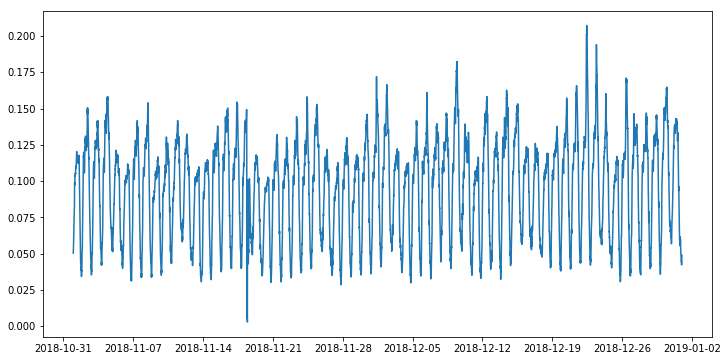

In [101]:
plt.figure(figsize=(12,6))
plt.plot(y2);

We can clearly see a seasonal (weekly) trend in our data, which makes sense given that rideshare demand would show a seasonal trend.

In [51]:
y2.index.names = ['ds']

We divide our dataset into training and test, so that we can see how well do we generalise. The split will be 80-20.

In [53]:
split = int(0.8*(len(y2)))
train = y2.iloc[:split,:].reset_index()
test = y2.iloc[split:,:].reset_index()

In [54]:
print(y2.shape)
print(train.shape)
print(test.shape)

(5856, 1)
(4684, 2)
(1172, 2)


In [55]:
import fbprophet as Prophet
from sklearn.metrics import mean_squared_error

In [56]:
m = Prophet.Prophet(seasonality_mode='additive', weekly_seasonality=True, 
                    daily_seasonality=True)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



### 5.1.1 Train Error

In [57]:
future = train
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4679,2018-12-19 17:45:00,0.056850,0.040493,0.073482
4680,2018-12-19 18:00:00,0.054124,0.037766,0.069795
4681,2018-12-19 18:15:00,0.051654,0.034921,0.067826
4682,2018-12-19 18:30:00,0.049471,0.033632,0.066160
4683,2018-12-19 18:45:00,0.047604,0.031642,0.063831


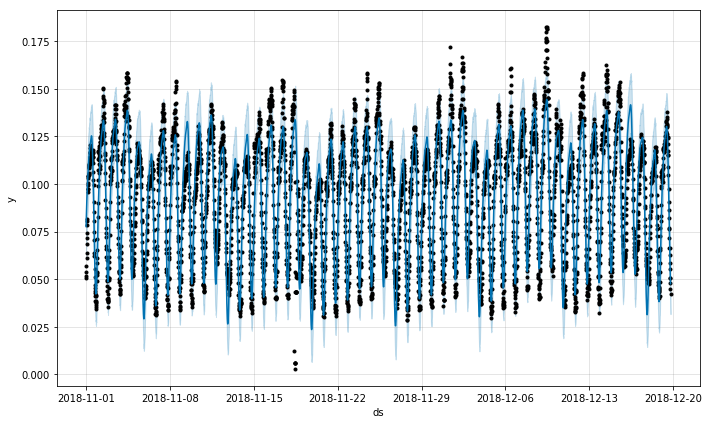

In [58]:
fig1 = m.plot(forecast)

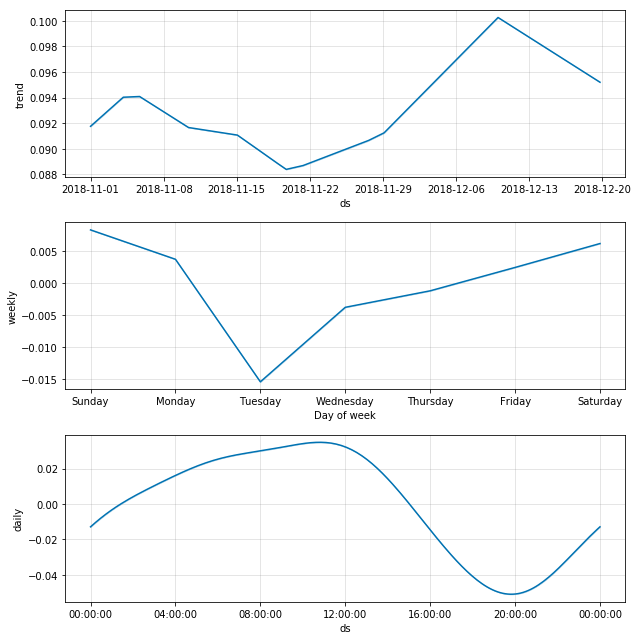

In [59]:
fig2 = m.plot_components(forecast)

In [60]:
rmse = np.sqrt(mean_squared_error(train['y'], forecast['yhat']))
print(rmse)

0.012631165758004569


We got a pretty good (low) training RMSE. However, we need to see how our predictive/forecast model performs on a new dataset (the held-out test dataset).

### 5.1.2 Test Error

In [61]:
future = test
#future = m.make_future_dataframe(periods=5, freq='15Min')

In [62]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1167,2018-12-31 22:45:00,0.046067,0.028427,0.063664
1168,2018-12-31 23:00:00,0.049101,0.031326,0.065901
1169,2018-12-31 23:15:00,0.052105,0.033321,0.068869
1170,2018-12-31 23:30:00,0.055042,0.038385,0.072124
1171,2018-12-31 23:45:00,0.057879,0.040605,0.075440


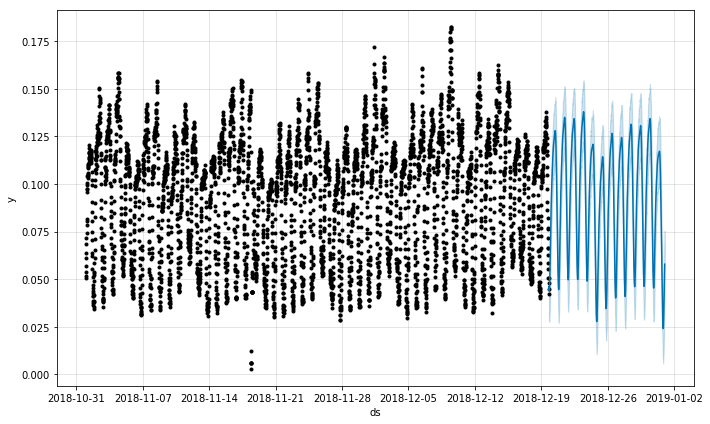

In [63]:
fig1 = m.plot(forecast)

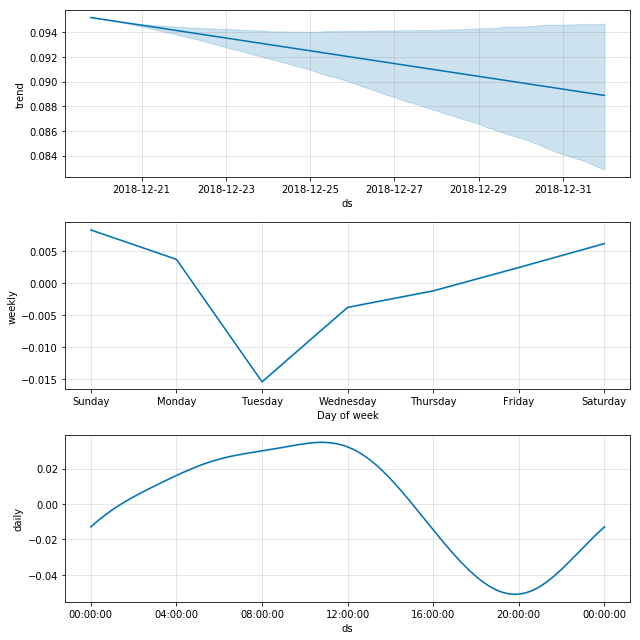

In [64]:
fig2 = m.plot_components(forecast)

In [65]:
test.y.describe()

count    1172.000000
mean        0.101591
std         0.037698
min         0.030758
25%         0.065883
50%         0.109627
75%         0.129730
max         0.207298
Name: y, dtype: float64

In [66]:
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
print(rmse)

0.01660641648840118


We see that our Prophet model does a very good job with forecasting on the test set. We get a root mean-squared error of 0.0166, which is low. Our minimum demand value, for the test set is 0.030758 and maximum value is 0.207298 with a mean of 0.101591. 

## 5.2 Forecasting with Geohash

Now we incorporate geohash in our analysis to see if we can further reduce the error. The location provides further granularity to our dataset.

In [67]:
df.head()

,geohash6,day,timestamp,demand,hour,minute,day_mod_7,month,year,day_of_month,datetime
2289,qp09sx,1,0:0,0.021212,0,0,1,11,2018,1,2018-11-01
3149,qp0dhg,1,0:0,0.013217,0,0,1,11,2018,1,2018-11-01
11052,qp03x5,1,0:0,0.157956,0,0,1,11,2018,1,2018-11-01
23011,qp09bw,1,0:0,0.001262,0,0,1,11,2018,1,2018-11-01
26180,qp03wn,1,0:0,0.032721,0,0,1,11,2018,1,2018-11-01


In [68]:
df['geohash6'].value_counts()[0:10]

qp03wz    5846
qp03yb    5846
qp03xw    5846
qp03wf    5846
qp09e5    5845
qp0987    5845
qp03xm    5845
qp092m    5845
qp03qg    5845
qp03w9    5845
Name: geohash6, dtype: int64

We see that there are 1,329 unique geohashes, and quite a few of them have very little values. Since the hashes are anonymised, we are not sure of their actual location in the world. So, we have to deal with them arbitrarily. We will use label encoding, that will ensure that the geohashes are put into classes. We can then use the existing feature of Prophet library called add_regressor, and add that geolocation as an additional regressor in our model. 

In [69]:
from sklearn.preprocessing import LabelEncoder

In [70]:
label = LabelEncoder()
df['geo_labels'] = label.fit_transform(df['geohash6'])

In [71]:
y_geo = df[['demand', 'datetime', 'geo_labels']]

In [72]:
y_geo.columns = ['y', 'ds', 'geo_labels']

I tried training with the complete dataset, and it was taking too long. For the benefit of timesaving, it is better to use few locations (maybe the top 50).

In [73]:
top_5_geo = list(y_geo['geo_labels'].value_counts().index[0:5])

In [74]:
y_geo = y_geo[y_geo['geo_labels'].isin(top_5_geo)]

In [75]:
y_geo.head()

,y,ds,geo_labels
81545,0.244790,2018-11-01,275
1112150,0.449159,2018-11-01,822
3853178,0.279437,2018-11-01,215
4048608,0.424474,2018-11-01,261
4117178,0.406610,2018-11-01,232


In [76]:
split = int(0.8*(len(y_geo)))
train = y_geo.iloc[:split,:].reset_index()
test = y_geo.iloc[split:,:].reset_index()

In [77]:
m2 = Prophet.Prophet()
m2.add_regressor('geo_labels')
m2.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [78]:
future = train[['ds','geo_labels']]
forecast = m2.predict(future)

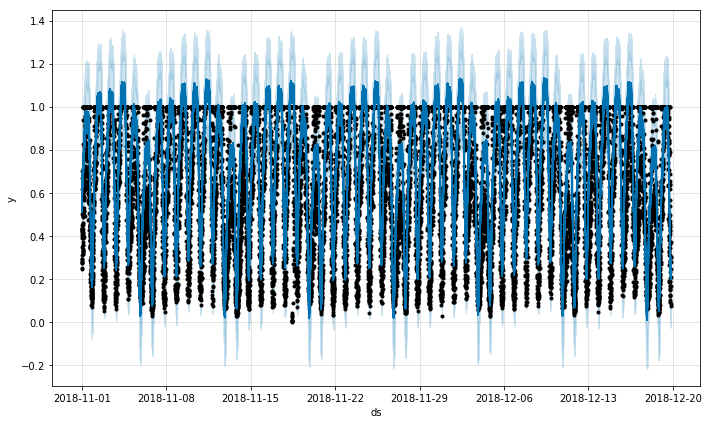

In [79]:
fig1 = m2.plot(forecast)

In [80]:
rmse = np.sqrt(mean_squared_error(train['y'], forecast['yhat']))
print(rmse)

0.17515634155795326


In [81]:
future = test[['ds','geo_labels']]
forecast = m2.predict(future)

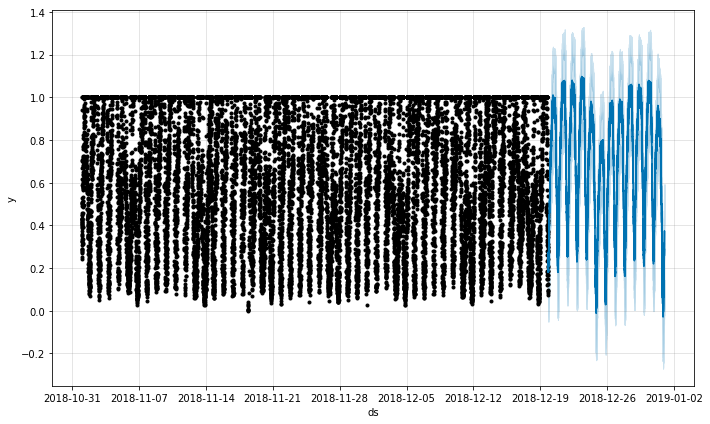

In [82]:
fig1 = m2.plot(forecast)

In [83]:
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
print(rmse)

0.16717803799513886


We get a pretty huge RMSE, even on our training data, which suggests that only the top 5 most frequent geohashes regressors was probably not a good idea. And adding more geohashes makes the training very long. So, I will focus only on the model without geohashes.

# 6. How to Run the Model on Held-Out Data

This section will entail the lines of code that will run the held-out dataset against which the model will be assessed. Assumption to run the below cells:
- The datetime is in python datetime format (YYYY-MM-DD HH:MM:SS)

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet as Prophet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing  import LabelEncoder

In [87]:
# Read in the held out dataset
df = pd.read_csv(...)

In [ ]:
# Prepare the dataset
df_test = df['demand', 'timestamp']
df_test = df_test.columns = ['y', 'ds']

In [ ]:
# train prophet model from existing training data 
# add 14 consecutive held-out dataset rows
y2.reset_index(inplace=True)
y2.append(df_test.iloc[0:14,:])
m = Prophet.Prophet()
m.fit(y2)

In [ ]:
# make forecast on held-out data
# we will make prediction after our trained data + 14 rows of held-out data
future = m.make_future_dataframe(periods=5, freq='15Min')
forecast = m.predict(future)

In [ ]:
# plot the forecast
fig1 = m.plot(forecast)

In [ ]:
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(df_test['y'], forecast['yhat']))
print(rmse)